#### Get text and duration dataframe

In [1]:
from collections import Counter

import torch
import torch.nn.functional as F

import os
import pandas as pd
import numpy as np
from navec import Navec
from slovnet.model.emb import NavecEmbedding
from typing import Union, List, Optional
import seaborn as sns
import pymorphy3
import nltk
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import matplotlib.pyplot as plt
from pathlib import Path
import torch.nn as nn
from copy import deepcopy
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset, Features, Value, ClassLabel
from enum import Enum


from config import *

/data/vkiselev/projects/univer/deploma/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

%load_ext autoreload
%autoreload all

In [3]:
DEPLOMA_DIR_PATH = Path('/home/vkiselev/data/other/univer/deploma')
DUSHA_DIR_PATH = DEPLOMA_DIR_PATH / 'dusha'
DUSHA_CROWD_DIR_PATH = DUSHA_DIR_PATH / 'crowd'
DUSHA_CROWD_TRAIN_DIR_PATH = DUSHA_CROWD_DIR_PATH / 'crowd_train/'
DUSHA_CROWD_TRAIN_FILE_PATH = DUSHA_CROWD_TRAIN_DIR_PATH/ 'raw_crowd_train.tsv'
DUSHA_TEST_PATH = DUSHA_CROWD_DIR_PATH / 'crowd_test/'
raw_crowd_test_path = DUSHA_TEST_PATH / 'raw_crowd_test.tsv'
raw_crowd_test = pd.read_csv(raw_crowd_test_path ,sep='\t')
text_column_name = 'speaker_text'
duration_column_name = 'duration'
emotion_column_name = 'annotator_emo'

# word embeddings
HYPOTHESES_DIR_PATH = DEPLOMA_DIR_PATH / 'hypotheses'
NAVEC_EMBEDDINGS_FILE_PATH = HYPOTHESES_DIR_PATH / 'navec_hudlit_v1_12B_500K_300d_100q.tar'  # 51MB

duration_text = raw_crowd_test[[text_column_name, duration_column_name, emotion_column_name]]
duration_text = duration_text.dropna()
duration_text.head(20)

,speaker_text,duration,annotator_emo
0,я слушаю,5.820000,neutral
1,каким стал сбер,3.700000,sad
2,где родился шерлок холмс,4.380000,neutral
3,открой в браузере ennio morricone,8.580000,neutral
4,каким стал сбер,3.700000,sad
5,я слушаю,5.820000,neutral
6,где родился шерлок холмс,4.380000,neutral
7,открой в браузере ennio morricone,8.580000,neutral
8,каким стал сбер,3.700000,sad
9,я слушаю,5.820000,neutral


In [4]:
raw_crowd_train = pd.read_csv(DUSHA_CROWD_TRAIN_FILE_PATH, sep='\t')
raw_crowd_train.head()

,hash_id,audio_path,duration,annotator_emo,golden_emo,annotator_id,speaker_text,speaker_emo,source_id
0,475e76f77ac1ed7cabafca740b15b32a,wavs/475e76f77ac1ed7cabafca740b15b32a.wav,2.453000,angry,NaN,858305a5450b7bd1288ba0053b1cd1c1,не надо не надо не надо не надо,angry,fa136da095807ea6cd18dd6e2f58d4d0
1,2f9438ef68395c70a8714dc373a49d11,wavs/2f9438ef68395c70a8714dc373a49d11.wav,4.640000,neutral,NaN,858305a5450b7bd1288ba0053b1cd1c1,фозил кори mp три,neutral,3d436884cbbe25373914f8768de494f7
2,9937036a9c0dba20eecbffddd00f2be2,wavs/9937036a9c0dba20eecbffddd00f2be2.wav,4.341750,neutral,2.0,858305a5450b7bd1288ba0053b1cd1c1,NaN,NaN,NaN
3,fb0ae78586a235018103acec22a80a8f,wavs/fb0ae78586a235018103acec22a80a8f.wav,3.900562,neutral,NaN,858305a5450b7bd1288ba0053b1cd1c1,сколько стоит на керамбит,neutral,80bc833cf6b3f106d2e8991783a31e2b
4,196dcf9e1aaac46c2aee45e7f6adfb92,wavs/196dcf9e1aaac46c2aee45e7f6adfb92.wav,4.780000,neutral,NaN,858305a5450b7bd1288ba0053b1cd1c1,афина когда закончится эта телепередача,neutral,bd78f079676fa5f1ed17253c9a440cc6


In [5]:
# DUSHA_TEST_PATH
raw_crowd_test.shape

(79088, 9)

In [6]:
raw_crowd_test.head()

,hash_id,audio_path,duration,annotator_emo,golden_emo,annotator_id,speaker_text,speaker_emo,source_id
0,9e9961c53ca6eeb440b217e539fbf46c,wavs/9e9961c53ca6eeb440b217e539fbf46c.wav,5.82,neutral,NaN,858305a5450b7bd1288ba0053b1cd1c1,я слушаю,neutral,4282ddc30d71ef420e202e0c60391e9f
1,0166f65a30354db8282682b1a280e64c,wavs/0166f65a30354db8282682b1a280e64c.wav,3.70,sad,NaN,858305a5450b7bd1288ba0053b1cd1c1,каким стал сбер,neutral,d70dc98ed56e9362eaefefb7b2827c8f
2,d49a6b560155831725a7bdc7d0a96099,wavs/d49a6b560155831725a7bdc7d0a96099.wav,4.38,neutral,NaN,858305a5450b7bd1288ba0053b1cd1c1,где родился шерлок холмс,neutral,0ee35d2abecf4272ecc8e1539b0839d8
3,c6852b0925797612d7b6724da8cbe7b4,wavs/c6852b0925797612d7b6724da8cbe7b4.wav,8.58,neutral,NaN,858305a5450b7bd1288ba0053b1cd1c1,открой в браузере ennio morricone,neutral,0855e363c1787df1592f58f7a27ebe13
4,0166f65a30354db8282682b1a280e64c,wavs/0166f65a30354db8282682b1a280e64c.wav,3.70,sad,NaN,a5562e26cd8f1949488a2d1e1e549d97,каким стал сбер,neutral,d70dc98ed56e9362eaefefb7b2827c8f


#### Word embeddings

In [28]:

# path = os.path.join(data_folder, file_name)

navec = Navec.load(NAVEC_EMBEDDINGS_FILE_PATH)  # ~1 sec, ~100MB RAM

words = ['навек', '<unk>', '<pad>']
ids = [navec.vocab[_] for _ in words]

emb = NavecEmbedding(navec)
vocab = navec.vocab
input = torch.tensor(ids)

emb(input).shape  # 3 x 300

NAVEC_EMBEDDINGS_SIZE = emb(input).shape[1]

/data/vkiselev/projects/univer/deploma/venv/lib/python3.11/site-packages/slovnet/model/emb.py:46: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  torch.from_numpy(navec.pq.indexes),


In [29]:
# emb(torch.tensor(navec.vocab['яма']))
def word_to_emb(word_or_words: Union[str, list[str]], emb=emb, vocab=vocab, embedding_size:int=NAVEC_EMBEDDINGS_SIZE) -> torch.Tensor:
    def single_word_to_emb(emb, vocab, word):
        return emb(torch.tensor(vocab[word]))
    if type(word_or_words) == list:
        result = []
        for word in word_or_words:
            try:
                word_emb = single_word_to_emb(emb, vocab, word)
            except KeyError:
                continue
            result.append(word_emb)
        if len(result) != 0:
            return torch.stack(result)
        else:
            return torch.zeros((1, embedding_size))
    else:
        return single_word_to_emb(emb, vocab, word_or_words)

example_word = 'кот'
default_embedding_size = word_to_emb(example_word).shape.numel()
word_to_emb(example_word).shape
# word_to_emb(emb, vocab, ['витя', 'ваня'])

torch.Size([300])

In [11]:
word_to_emb(['кот', 'собака', 'краб']).shape

torch.Size([3, 300])

In [12]:
type(vocab)
type(emb)

slovnet.model.emb.NavecEmbedding

In [13]:
def text_2_unified_tensor(
    text: str, 
    torch_unified_size:int = 49,
    word_tensor_length:int = 300,
    emb=emb, 
    vocab=vocab,
    ):
    words_list:List[str] = text.split()
    text_tensor:torch.Tensor = word_to_emb(words_list, emb=emb, vocab=vocab)
    # print('text_tensor.shape =', text_tensor.shape)

    zero_tensors_quantity: int = torch_unified_size - len(text_tensor)
    zero_tensor:torch.Tensor = torch.zeros((zero_tensors_quantity, word_tensor_length))
    # print('zero_tensor.shape =', zero_tensor.shape)
    filled_tensor:torch.Tensor = torch.concat([zero_tensor, text_tensor])
    # print('filled_tensor.shape =', filled_tensor.shape)

    return filled_tensor
    

text_2_unified_tensor('кот и собака')

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [-0.4161, -0.8234,  0.1041,  ..., -0.2127, -0.4413, -0.0091],
        [-0.0204, -0.4305, -0.3130,  ..., -0.3365, -0.1798,  0.2134],
        [-0.5378, -0.6289, -0.3964,  ...,  0.0626, -0.7265,  0.1321]])

In [19]:
def texts_series_2_tensor(
    s:pd.Series,
    torch_unified_size:int = 49,
    word_tensor_length:int = 300,
    emb=emb, 
    vocab=vocab,
    )->torch.Tensor:
    texts_list:List[str] = s.to_list()
    concatted_texts_embeddings:torch.Tensor = torch.stack(
        list(
            map(
                lambda x: text_2_unified_tensor(
                    text=x, 
                    torch_unified_size=torch_unified_size,
                    word_tensor_length=word_tensor_length,
                    emb=emb,
                    vocab=vocab,
                ),
                texts_list
            )
        )
    )

    # print('concatted_texts_embeddings.shape', concatted_texts_embeddings.shape)
    return concatted_texts_embeddings

texts_s = pd.Series(['кот и собака', 'я и мой друг иностранец'])

texts_series_2_tensor(texts_s).shape

NameError: name 'emb' is not defined

In [ ]:
def bag_of_words(emb, vocab, words: list[str], embedding_size = default_embedding_size) -> torch.Tensor:
    word_embeddings = word_to_emb(emb, vocab, words)
    vector_sum = torch.zeros(embedding_size)
    # if len(word_embeddings) > 0:
    for word in word_embeddings:
        vector_sum += word
    
    return vector_sum / max(len(word_embeddings), 1)

bag_of_words(emb, vocab, ['кот', 'телефон']).shape

TypeError: list indices must be integers or slices, not NavecEmbedding

In [ ]:
text_bags_of_words = []
for text in duration_text['speaker_text']:
    words = text.lower().split(' ')
    text_bags_of_words.append(bag_of_words(emb, vocab, words))

TypeError: list indices must be integers or slices, not NavecEmbedding

In [ ]:
text_bags_of_words_df = pd.DataFrame(text_bags_of_words, dtype='float')
duration_text_bags_of_words_df = pd.concat((duration_text, text_bags_of_words_df), axis=1)


In [ ]:
print(duration_text_bags_of_words_df.shape)
duration_text_bags_of_words_df.head()

(77833, 303)


,speaker_text,duration,annotator_emo,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
0,я слушаю,5.82,neutral,-0.197958,-0.149894,0.032033,-0.102101,-0.219139,-0.263596,-0.225147,0.258930,0.117051,0.100377,-0.324246,0.258904,-0.508715,-0.215503,0.210882,0.025488,-0.147110,-0.190629,0.025276,-0.075997,-0.391164,0.009545,-0.088486,0.355572,-0.191074,-0.106108,0.104446,0.028415,-0.365087,0.143028,-0.131791,-0.338319,0.686531,0.267851,0.270479,0.176184,-0.286627,-0.086951,0.477265,-0.036456,-0.133732,-0.251715,0.198817,-0.067004,-0.009029,-0.238308,-0.243764,0.087319,-0.516076,-0.528881,-0.456636,-0.244746,0.194040,0.261472,-0.256108,-0.010539,-0.027946,0.404871,0.304832,0.414624,0.264751,-0.202202,0.167245,0.127214,-0.081112,0.220268,0.026994,0.396083,0.021690,0.143788,0.101952,-0.157949,0.263012,-0.242352,-0.191445,0.160875,0.288398,-0.402036,0.055962,-0.068451,-0.186108,-0.110412,0.053057,0.005140,0.102799,0.162183,-0.240076,0.059766,-0.043052,0.120524,-0.309532,-0.178579,-0.170254,0.023768,-0.161257,0.363201,-0.340610,0.136231,-0.447222,0.023024,0.229478,0.415711,-0.064104,0.077425,-0.113667,-0.081131,-0.391203,-0.353643,0.074205,-0.199000,-0.510256,-0.212572,-0.138325,-0.082415,-0.152937,-0.026264,-0.188644,-0.084272,0.393173,-0.289402,0.516674,-0.089059,0.256436,-0.018781,-0.309682,0.048777,-0.532662,-0.461011,-0.024619,0.042296,-0.122076,-0.219262,-0.035282,-0.146745,-0.032820,0.148000,-0.118972,0.267165,-0.027189,-0.350919,0.346585,0.326107,-0.318082,0.022262,-0.274162,-0.482909,0.407158,-0.118547,0.007889,0.207699,-0.558207,-0.231710,0.504233,-0.486445,-0.202590,-0.039634,-0.045369,0.173775,0.277273,0.035539,-0.310294,-0.483012,-0.394369,-0.131762,0.086026,0.327311,0.041434,0.416462,-0.009464,0.442029,0.496967,0.219304,0.002189,0.278207,0.152812,-0.068644,-0.004169,0.268570,0.153320,-0.130606,-0.298030,-0.077796,-0.547992,0.115661,-0.481219,-0.642736,-0.022322,-0.046669,0.279620,0.768871,-0.613441,-0.348806,0.165565,-0.230899,-0.139432,0.437646,-0.179876,-0.176478,0.243698,0.124045,-0.078736,0.143348,-0.040742,0.144629,-0.196814,0.062156,0.254762,-0.264581,-0.212014,-0.147732,0.336298,-0.178571,-0.503756,-0.078845,-0.476782,0.195410,0.311677,0.133584,0.006194,0.382287,-0.169778,0.171826,-0.410383,-0.207939,-0.218626,0.156695,0.021147,-0.236488,-0.293818,-0.159312,0.084891,-0.240532,-0.053193,-0.137024,-0.067664,0.613337,-0.328087,-0.065717,0.249836,-0.026047,-0.429643,-0.080578,0.137631,0.243502,0.386829,-0.018077,-0.074276,0.109758,0.212163,0.030925,-0.166351,0.174804,0.260389,0.113725,0.410525,0.176767,-0.202720,-0.122002,-0.087963,-0.091891,0.137666,-0.254869,-0.422897,0.412493,-0.300738,0.070962,0.371799,-0.192057,-0.241452,0.645597,-0.081838,0.174949,0.122461,0.173219,-0.291513,-0.018067,-0.170438,0.379336,0.465803,0.414921,-0.021657,0.019548,-0.177907,0.418716,-0.037526,0.137094,0.079786,0.309050,-0.074114,0.350627,-0.068739,0.077948,-0.084094,0.113900,-0.028043,-0.415415,0.147565,-0.205027,-0.0

In [ ]:
embedding_feature_names = np.arange(0, default_embedding_size).tolist()
duration_embeddings_names = [duration_column_name] + embedding_feature_names
duration_text_bags_of_words_df[duration_embeddings_names]


In [ ]:
embeddings_corr = duration_text_bags_of_words_df[duration_embeddings_names].corr()

In [ ]:
embedding_threshold = 0.1

(embeddings_corr[duration_column_name].abs() > embedding_threshold).sum()
# embeddings_corr[duration_column_name].abs()

1

In [ ]:

punctuation = set(string.punctuation)


def tokens_normalization(transformations, tokens: list[str], delete_punctuation=False) -> list[str]:
    for transformation in transformations:
        tokens = map(transformation, tokens)
    
    if delete_punctuation:
        # tokens = map(lambda x: x.translate(punct_to_none), tokens)
        tokens = filter(lambda x: x not in punctuation, tokens)
        
    return list(tokens)

morph = pymorphy3.MorphAnalyzer()
lemmatizer = lambda x: morph.parse(x)[0].normal_form
transformations = [str.lower, lemmatizer]

tokens_normalization(transformations, ['КоТики'])
tokens_normalization(transformations, [','])

tokenizer_language = 'russian'

tokenizer = lambda x: nltk.word_tokenize(x, language=tokenizer_language)

def text_to_normalized_tokens(text: str, delete_punctuation=False) -> list[str]:
    tokens = tokenizer(text)
    normalized_tokens = tokens_normalization(transformations, tokens, delete_punctuation)
    
    return normalized_tokens

text_to_normalized_tokens('Коты, баОбабы', True)

['кот', 'баобаб']

In [ ]:
path = './tf-idf'
token_dict = {}


# def tokenize(text):
#     tokens = nltk.word_tokenize(text)
#     stems = []
#     for item in tokens:
#         stems.append(PorterStemmer().stem(item))
#     return stems

# for dirpath, dirs, files in os.walk(path):
#     for f in files:
#         fname = os.path.join(dirpath, f)
#         print ("fname=", fname)
#         with open(fname) as pearl:
#             text = pearl.read()
#             token_dict[f] = text.lower().translate(None, string.punctuation)

tfidf = TfidfVectorizer(tokenizer=text_to_normalized_tokens, stop_words='english')
tfs = tfidf.fit_transform(['cat dog', 'dog bug'])

s = 'milk milk milk bug bug, dog'
response = tfidf.transform([s])
print(response)

# feature_names = tfidf.get_feature_names()
# for col in response.nonzero()[1]:
#     print (feature_names[col], ' - ', response[0, col])

  (0, 0)	0.9421556246632359
  (0, 2)	0.33517574332792605


/home/viktor/Projects/Univer/Deploma/.venv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [ ]:

def texts_to_tfidf_dict(texts):
    # Initialize the TF-IDF vectorizer
    tfidf_vectorizer = TfidfVectorizer(tokenizer=text_to_normalized_tokens)

    # Fit and transform the text data
    tfidf_matrix = tfidf_vectorizer.fit_transform(texts)

    # Get the feature names (words) from the TF-IDF vectorizer
    feature_names = tfidf_vectorizer.get_feature_names_out()

    # Get the TF-IDF values for each word in the text data
    tfidf_values = tfidf_matrix.toarray()

    # Find the most important words based on their TF-IDF values
    most_important_words = {}
    for i, sentence in tqdm(enumerate(texts)):
        for word in text_to_normalized_tokens(sentence, True):
            word_index = np.where(np.array(feature_names) == word)[0]
            if len(word_index) > 0:
                word_index = word_index[0]
                tfidf_score = tfidf_values[i, word_index]
                if word in most_important_words:
                    most_important_words[word] = max(most_important_words[word], tfidf_score)
                else:
                    most_important_words[word] = tfidf_score


    return most_important_words

english_texts = [
    'This is a sample sentence.',
    'Another example a sentence for demonstration purposes.',
    'My name is Viktor',
    'A dog is not cat'
    'Sample sentences help in understanding a TF-IDF vectorization.'
]
russion_texts = [
    'Мама мыла раму.',
    'Мой дядя самых честных правил.',
    'Мой дядя мыл раму дома.',
    'Дома нельзя нарушать правила.'
]

word_to_tfidf = texts_to_tfidf_dict(russion_texts)
word_to_tfidf

4it [00:00, 1001.86it/s]


{'мама': 0.6305035039117027,
 'мыло': 0.4970962045265468,
 'рама': 0.4970962045265468,
 'мой': 0.42882143251767496,
 'дядя': 0.42882143251767496,
 'самый': 0.4916456170427456,
 'честной': 0.4916456170427456,
 'правило': 0.42049336953280086,
 'дом': 0.42882143251767496,
 'нельзя': 0.5333425209202354,
 'нарушать': 0.5333425209202354}

In [ ]:
speakers_texts = duration_text_bags_of_words_df['speaker_text'].to_list()
speaker_tfidf_dict = texts_to_tfidf_dict(speakers_texts)

77833it [01:37, 794.93it/s]


In [ ]:
len(speaker_tfidf_dict)

10482

In [ ]:
def text_to_mean_tfidf(text, tfidf_dict=speaker_tfidf_dict, tokenizer=text_to_normalized_tokens):
    tokens = tokenizer(text)
    sum_tfidf = 0
    for token in tokens:
        tfidf = tfidf_dict.get(token)
        if tfidf is not None:
            sum_tfidf += tfidf
    return sum_tfidf / max(len(tokens), 1)

text_to_mean_tfidf(russion_texts[0])

0.3541184417614869

In [ ]:
all_features = duration_text_bags_of_words_df
all_features.head()

,speaker_text,duration,annotator_emo,0,1,2,3,4,5,6,...,290,291,292,293,294,295,296,297,298,299
0,я слушаю,5.82,neutral,-0.197958,-0.149894,0.032033,-0.102101,-0.219139,-0.263596,-0.225147,...,-0.068739,0.077948,-0.084094,0.113900,-0.028043,-0.415415,0.147565,-0.205027,-0.019849,0.055699
1,каким стал сбер,3.70,sad,0.062094,-0.474676,-0.409619,0.015491,-0.104335,-0.269172,-0.068685,...,-0.213001,-0.233934,-0.219408,-0.407954,0.156611,-0.036210,-0.002245,-0.142691,-0.161408,0.285355
2,где родился шерлок холмс,4.38,neutral,-0.199201,-0.201970,-0.107651,0.102246,0.001738,-0.182565,-0.134217,...,-0.142165,-0.002077,-0.073691,-0.169712,0.187998,-0.286952,0.018901,-0.215588,-0.194586,-0.000220
3,открой в браузере ennio morricone,8.58,neutral,0.136984,-0.363209,-0.340083,0.231929,-0.179154,0.081780,0.023477,...,-0.294220,0.183978,0.257248,-0.128505,0.063109,-0.345005,0.086596,0.171087,0.158903,-0.257887
4,каким стал сбер,3.70,sad,0.062094,-0.474676,-0.409619,0.015491,-0.104335,-0.269172,-0.068685,...,-0.213001,-0.233934,-0.219408,-0.407954,0.156611,-0.036210,-0.002245,-0.142691,-0.161408,0.285355


In [ ]:
mean_tfidf_column_name = 'mean_tfidf'
all_features[mean_tfidf_column_name] = all_features['speaker_text'].apply(lambda x: text_to_mean_tfidf(x))

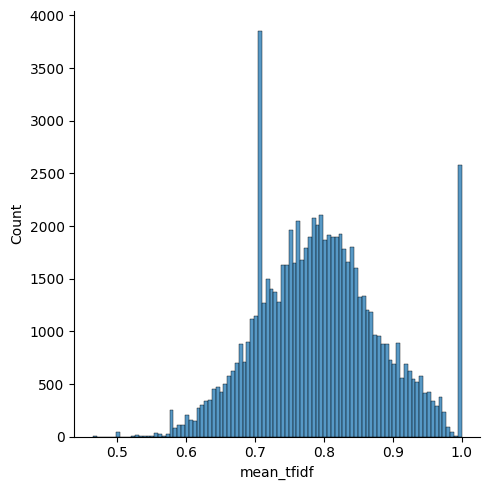

In [ ]:
# penguins = sns.load_dataset("penguins")
sns.displot(all_features[mean_tfidf_column_name].to_frame(), x=mean_tfidf_column_name)
# penguins.head()

In [ ]:
# all_features.head()['speaker_text'].apply(lambda x: text_to_mean_tfidf(x))
all_features[mean_tfidf_column_name]

0        0.940797
1        0.815491
2        0.721205
3        0.705724
4        0.815491
           ...   
77828    0.654353
77829    0.725484
77830    0.725484
77831    0.725484
77832    0.725484
Name: mean_tfidf, Length: 77833, dtype: float64

First axis - texts, second - words 

In [ ]:
all_features[['duration', mean_tfidf_column_name]].corr()

,duration,mean_tfidf
duration,1.000000,-0.153973
mean_tfidf,-0.153973,1.000000


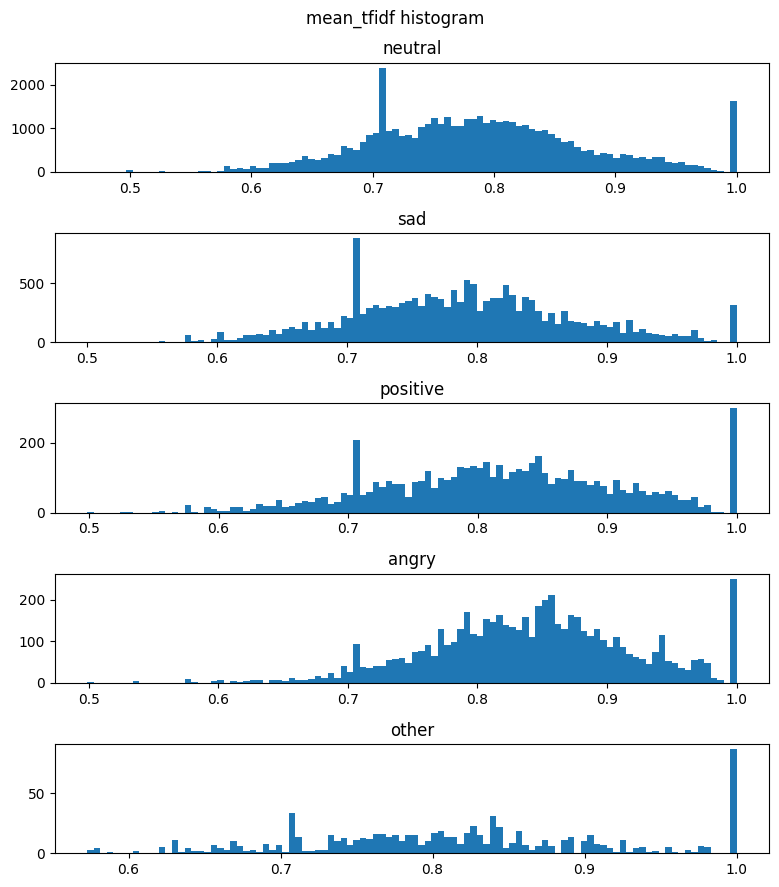

In [ ]:
emotions = all_features[emotion_column_name].unique()
bins_number = 100
# plt.hist()
fig, axs = plt.subplots(len(emotions), figsize=(8,9))
fig.suptitle(f'{mean_tfidf_column_name} histogram')
fig.tight_layout()
for i in range(len(emotions)):
    fig.tight_layout()
    axs[i].hist(all_features[all_features[emotion_column_name] == emotions[i]][mean_tfidf_column_name], bins=bins_number)
    axs[i].set_title(emotions[i])
    # axs[i].plot(x, -y)
# plt.hist(all_features[all_features['annotator_emo'] == emotions[1]]['duration'], bins=bins_number)
None

In [ ]:
# describe_emotion_by_tfidf = pd.DataFrame()
describe_emotion_by_tfidf= None
for i in range(len(emotions)):
    emotion = emotions[i]
    describe_series = all_features[all_features[emotion_column_name] == emotions[i]][mean_tfidf_column_name].describe()
    if describe_emotion_by_tfidf is None:
        describe_emotion_by_tfidf = describe_series.to_frame()
        # describe_emotion_by_tfidf = describe_emotion_by_tfidf.rename({describe_series.name: emotion})
        describe_emotion_by_tfidf = describe_emotion_by_tfidf.drop(columns=[describe_series.name])
    describe_emotion_by_tfidf[emotion] = describe_series
    
    
describe_emotion_by_tfidf

,neutral,sad,positive,angry,other
count,48578.000000,16690.000000,5775.000000,5987.000000,803.000000
mean,0.787087,0.787701,0.818064,0.840895,0.817951
std,0.089057,0.084357,0.093656,0.079275,0.101059
min,0.464837,0.499990,0.498693,0.498911,0.572848
25%,0.720509,0.726119,0.753776,0.790302,0.750168
50%,0.782334,0.786439,0.817869,0.843588,0.814536
75%,0.840812,0.839698,0.881562,0.891613,0.886127
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
describe_emotion_by_tfidf = all_features[all_features[emotion_column_name] == emotions[i]][mean_tfidf_column_name].describe()
# describe_emotion_by_tfidf.add()

describe_emotion_by_tfidf.to_frame().rename({describe_emotion_by_tfidf.name: '123'})

,mean_tfidf
count,803.000000
mean,0.817951
std,0.101059
min,0.572848
25%,0.750168
50%,0.814536
75%,0.886127
max,1.000000


##### Average coords value for all emotion types

In [ ]:
all_features.head()
# for emotion in emotions:
    # all_features[all_features[emotion_column_name] == emotion][[str(i) for i in range(0, 300)]].mean(axis=0)

embedding_feautes = [i for i in range(0, 300)]
embedding_feautes.append(emotion_column_name)
embedding_feautes
all_features[embedding_feautes].groupby(emotion_column_name).mean()
# all_features.columns

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
annotator_emo,,,,,,,,,,,,,,,,,,,,,
angry,-0.048325,-0.159754,-0.099051,-0.003465,-0.126016,-0.210903,0.111279,0.139091,0.022637,-0.141279,...,0.027198,0.158465,-0.019262,0.040426,0.026666,-0.317182,0.084268,-0.097220,-0.123976,0.157442
neutral,0.031516,-0.163326,-0.069133,-0.001985,-0.054704,-0.145235,0.102531,0.072719,0.073665,-0.087258,...,0.057389,0.019774,0.016290,0.035793,0.055911,-0.203372,0.010343,-0.082535,-0.024856,0.132959
other,0.001175,-0.141374,-0.052648,0.003718,-0.083738,-0.162969,0.105705,0.086705,0.010688,-0.127806,...,0.052578,0.075943,-0.007231,0.040757,0.023184,-0.216984,0.031257,-0.122045,-0.066357,0.131827
positive,-0.007904,-0.159592,-0.081678,0.021480,-0.100774,-0.158541,0.121289,0.087906,0.015392,-0.147423,...,0.027748,0.066459,-0.027828,0.069709,0.012820,-0.258133,0.070571,-0.169416,-0.048735,0.158280
sad,0.040792,-0.167781,-0.077883,0.005924,-0.045108,-0.146117,0.104099,0.068894,0.079180,-0.098872,...,0.058638,0.015368,0.024363,0.041003,0.047069,-0.215688,0.013315,-0.085333,-0.034482,0.139860


#### Emotions key words

In [ ]:
text_emo_df = all_features[[text_column_name, emotion_column_name]].copy()
text_emo_df.head()

,speaker_text,annotator_emo
0,я слушаю,neutral
1,каким стал сбер,sad
2,где родился шерлок холмс,neutral
3,открой в браузере ennio morricone,neutral
4,каким стал сбер,sad


In [ ]:
sample = text_emo_df[text_column_name].head()
    
# emotion_word_counter
emotion_word_counter_dict = {}
for emotion in emotions:
    current_emotion_subdf = text_emo_df[text_emo_df[emotion_column_name] == emotion][text_column_name]
    emotion_word_counter = Counter({})
    
    for text in current_emotion_subdf:
        emotion_word_counter.update(text_to_normalized_tokens(text))
    emotion_word_counter_dict[emotion] = emotion_word_counter
    

In [ ]:
text_emo_df.shape

(77833, 2)

In [ ]:
for emotion, word_counter in emotion_word_counter_dict.items():
    print(emotion, ':', list(word_counter.most_common(10)))

neutral : [('я', 3555), ('ты', 3371), ('в', 2771), ('включить', 2760), ('на', 2746), ('фильм', 2401), ('песня', 2027), ('что', 2021), ('как', 1740), ('не', 1730)]
sad : [('я', 1607), ('включить', 1167), ('на', 982), ('ты', 947), ('не', 883), ('в', 815), ('фильм', 755), ('песня', 670), ('как', 646), ('серия', 615)]
positive : [('я', 1242), ('ты', 1174), ('а', 394), ('у', 313), ('салют', 300), ('с', 292), ('в', 292), ('как', 280), ('на', 277), ('что', 263)]
angry : [('ты', 2448), ('я', 1431), ('не', 1060), ('что', 741), ('а', 354), ('в', 320), ('блядь', 311), ('на', 281), ('это', 273), ('как', 257)]
other : [('ты', 150), ('я', 91), ('что', 68), ('не', 59), ('а', 41), ('в', 37), ('на', 34), ('как', 29), ('песня', 29), ('хотеть', 28)]


Most significant words in each emotion

In [ ]:
word_occurancy_in_specific_emotion_ratio = 0.02
most_common_words_number = 10

emotion_most_common_words = {}

for emotion, word_counter in emotion_word_counter_dict.items():
    word_tfidf = []
    for word, occurances_number in emotion_word_counter_dict[emotion].items():
        # count occurances number of this word in all corpus of texts
        if occurances_number/len(emotion_word_counter_dict[emotion]) > word_occurancy_in_specific_emotion_ratio:
            total_occurances_number = 0
            for word_counter in emotion_word_counter_dict.values():
                total_occurances_number += word_counter[word]
            
            word_tfidf.append((word, occurances_number/total_occurances_number))
    
    word_tfidf.sort(key=lambda x: -x[1])
    emotion_most_common_words[emotion] = word_tfidf[:most_common_words_number]

for emotion, words in emotion_most_common_words.items():
    print(emotion, ':', words)


neutral : [('окко', 0.8310344827586207), ('запустить', 0.8305084745762712), ('третий', 0.799410029498525), ('пятый', 0.7837837837837838), ('майнкрафт', 0.7649253731343284), ('тв', 0.7574468085106383), ('клип', 0.7365010799136069), ('супер', 0.735191637630662), ('влад', 0.734982332155477), ('фильм', 0.7342507645259939)]
sad : [('тогда', 0.41832669322709165), ('новость', 0.4162303664921466), ('пять', 0.36192109777015435), ('делать', 0.34063745019920316), ('кино', 0.3377926421404682), ('мультик', 0.32554744525547447), ('мультфильм', 0.3216374269005848), ('машина', 0.31754874651810583), ('второй', 0.30781758957654726), ('большой', 0.2995169082125604)]
positive : [('купаться', 0.7653061224489796), ('молодец', 0.5763888888888888), ('ха', 0.5620915032679739), ('салют', 0.4754358161648177), ('привет', 0.4660633484162896), ('красивый', 0.4553191489361702), ('приятно', 0.45454545454545453), ('спасибо', 0.45318352059925093), ('лайк', 0.4175257731958763), ('тоже', 0.37850467289719625)]
angry : [('

In [ ]:
top_words_quantity = 3
dirty_words = set(['нахуй', 'блядь', 'сука', 'хуй'])
def average_cosine_distance_with_word_emb(df: pd.DataFrame, word_emb: torch.Tensor):
    emodtion_embeddings_cols = list(range(300))
    df_tensor = torch.Tensor(df[emodtion_embeddings_cols].values)
    
    
    word_normalized_emb = F.normalize(word_emb, p=2, dim=0)
    df_normalized_tensor = F.normalize(df_tensor, p=2, dim=1)
    
    
    dot_products = torch.matmul(df_normalized_tensor, word_normalized_emb)
    cosine_distance = 1 - dot_products

    return cosine_distance.mean()

key_word_emotion_df = pd.DataFrame()
for _, words in emotion_most_common_words.items():
    word_i = 0
    words_counter = 0
    while words_counter < top_words_quantity:
    # for word, _ in words[:top_words_quantity]:
        # get word embedding
        word, _ = words[word_i]
        if word in dirty_words:
            symbols_list = list(word)
            symbols_list[0] = '*'
            word = ''.join(symbols_list)
        word_i += 1
        
        current_word_embedding = None
        
        try:
            current_word_embedding = word_to_emb(emb, vocab, word)
        except KeyError:
            continue
        
        average_cosine_distances = []
        for emotion in emotions:
            
            average_cosine_distance = float(average_cosine_distance_with_word_emb(all_features[all_features[emotion_column_name] == emotion], current_word_embedding))
            average_cosine_distances.append(average_cosine_distance)
        
        # print(pd.Series(index=emotions, data=average_cosine_distances))
        key_word_emotion_df[word] = pd.Series(index=emotions, data=average_cosine_distances)
        words_counter += 1
        # count average cosine distance in corpus of text for every emotion
        
key_word_emotion_df

# build plots for every word, group plots by emotion 

,запустить,третий,пятый,тогда,новость,пять,купаться,молодец,ха,тупой,дура,дебил,смешно,крутой,мама
neutral,0.909431,0.783161,0.822833,0.712553,0.857481,0.774207,0.907346,0.820428,0.830249,0.935601,0.836376,0.970031,0.821935,0.898952,0.751516
sad,0.908368,0.779386,0.819216,0.702571,0.852567,0.764612,0.901919,0.815842,0.824474,0.932452,0.829856,0.971758,0.812723,0.899351,0.735599
positive,0.922701,0.756012,0.813952,0.630018,0.799379,0.735959,0.874604,0.711147,0.748354,0.913652,0.759262,0.959449,0.744817,0.866759,0.642523
angry,0.905357,0.744677,0.814870,0.571160,0.806594,0.722065,0.871401,0.697538,0.703461,0.845547,0.635150,0.858263,0.703377,0.867078,0.615922
other,0.925060,0.790630,0.844921,0.675763,0.843223,0.775076,0.895923,0.778215,0.785205,0.917098,0.775290,0.936958,0.783456,0.894292,0.704513


In [ ]:
key_word_emotion_df.shape

(5, 15)

In [ ]:
all_features[all_features[emotion_column_name] == 'sad']

,speaker_text,duration,annotator_emo,0,1,2,3,4,5,6,...,291,292,293,294,295,296,297,298,299,mean_tfidf
1,каким стал сбер,3.700000,sad,0.062094,-0.474676,-0.409619,0.015491,-0.104335,-0.269172,-0.068685,...,-0.233934,-0.219408,-0.407954,0.156611,-0.036210,-0.002245,-0.142691,-0.161408,0.285355,0.815491
4,каким стал сбер,3.700000,sad,0.062094,-0.474676,-0.409619,0.015491,-0.104335,-0.269172,-0.068685,...,-0.233934,-0.219408,-0.407954,0.156611,-0.036210,-0.002245,-0.142691,-0.161408,0.285355,0.815491
8,каким стал сбер,3.700000,sad,0.062094,-0.474676,-0.409619,0.015491,-0.104335,-0.269172,-0.068685,...,-0.233934,-0.219408,-0.407954,0.156611,-0.036210,-0.002245,-0.142691,-0.161408,0.285355,0.815491
18,позови мне кого нибудь другого лезть,5.247312,sad,-0.136066,-0.156883,-0.077527,-0.037078,-0.171148,-0.274264,0.136021,...,0.254096,0.028773,-0.019775,0.144353,-0.126587,-0.103447,-0.074806,-0.336040,0.038066,0.789401
36,у меня зуб выпадал,2.577000,sad,-0.196443,-0.196155,-0.055705,-0.202940,-0.122482,-0.106701,0.106749,...,0.072931,-0.189355,-0.131699,0.072780,-0.318196,-0.167991,-0.345626,-0.060804,0.085541,0.822609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77823,включи игру слова наоборот,5.160000,sad,0.198895,-0.278133,0.075254,0.062992,-0.155318,-0.095221,0.015344,...,0.221494,0.120578,-0.061261,0.028258,-0.366848,-0.030970,-0.004477,-0.088137,0.423792,0.883928
77829,львиная семейка,6.220000,sad,-0.084114,0.309478,0.106910,-0.364904,-0.243569,-0.412665,-0.085683,...,0.188963,0.021591,-0.234522,-0.214289,-0.019569,0.245924,0.428772,0.088778,0.031588,0.725484
77830,львиная семейка,6.220000,sad,-0.084114,0.309478,0.106910,-0.364904,-0.243569,-0.412665,-0.085683,...,0.188963,0.021591,-0.234522,-0.214289,-0.019569,0.245924,0.428772,0.088778,0.031588,0.725484
77831,львиная семейка,6.220000,sad,-0.084114,0.309478,0.106910,-0.364904,-0.243569,-0.412665,-0.085683,...,0.188963,0.021591,-0.234522,-0.214289,-0.019569,0.245924,0.428772,0.088778,0.031588,0.725484


<Axes: ylabel='пять'>

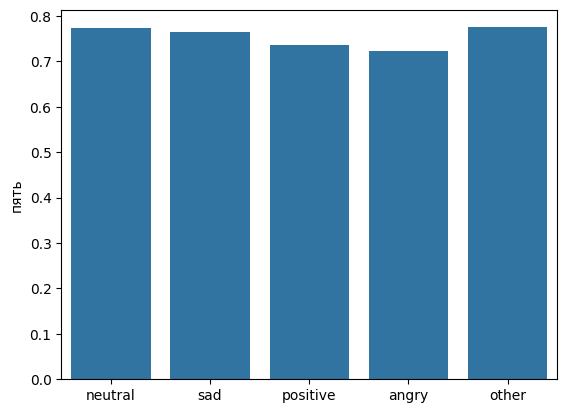

In [ ]:
sns.barplot(data=key_word_emotion_df.iloc[:,5])

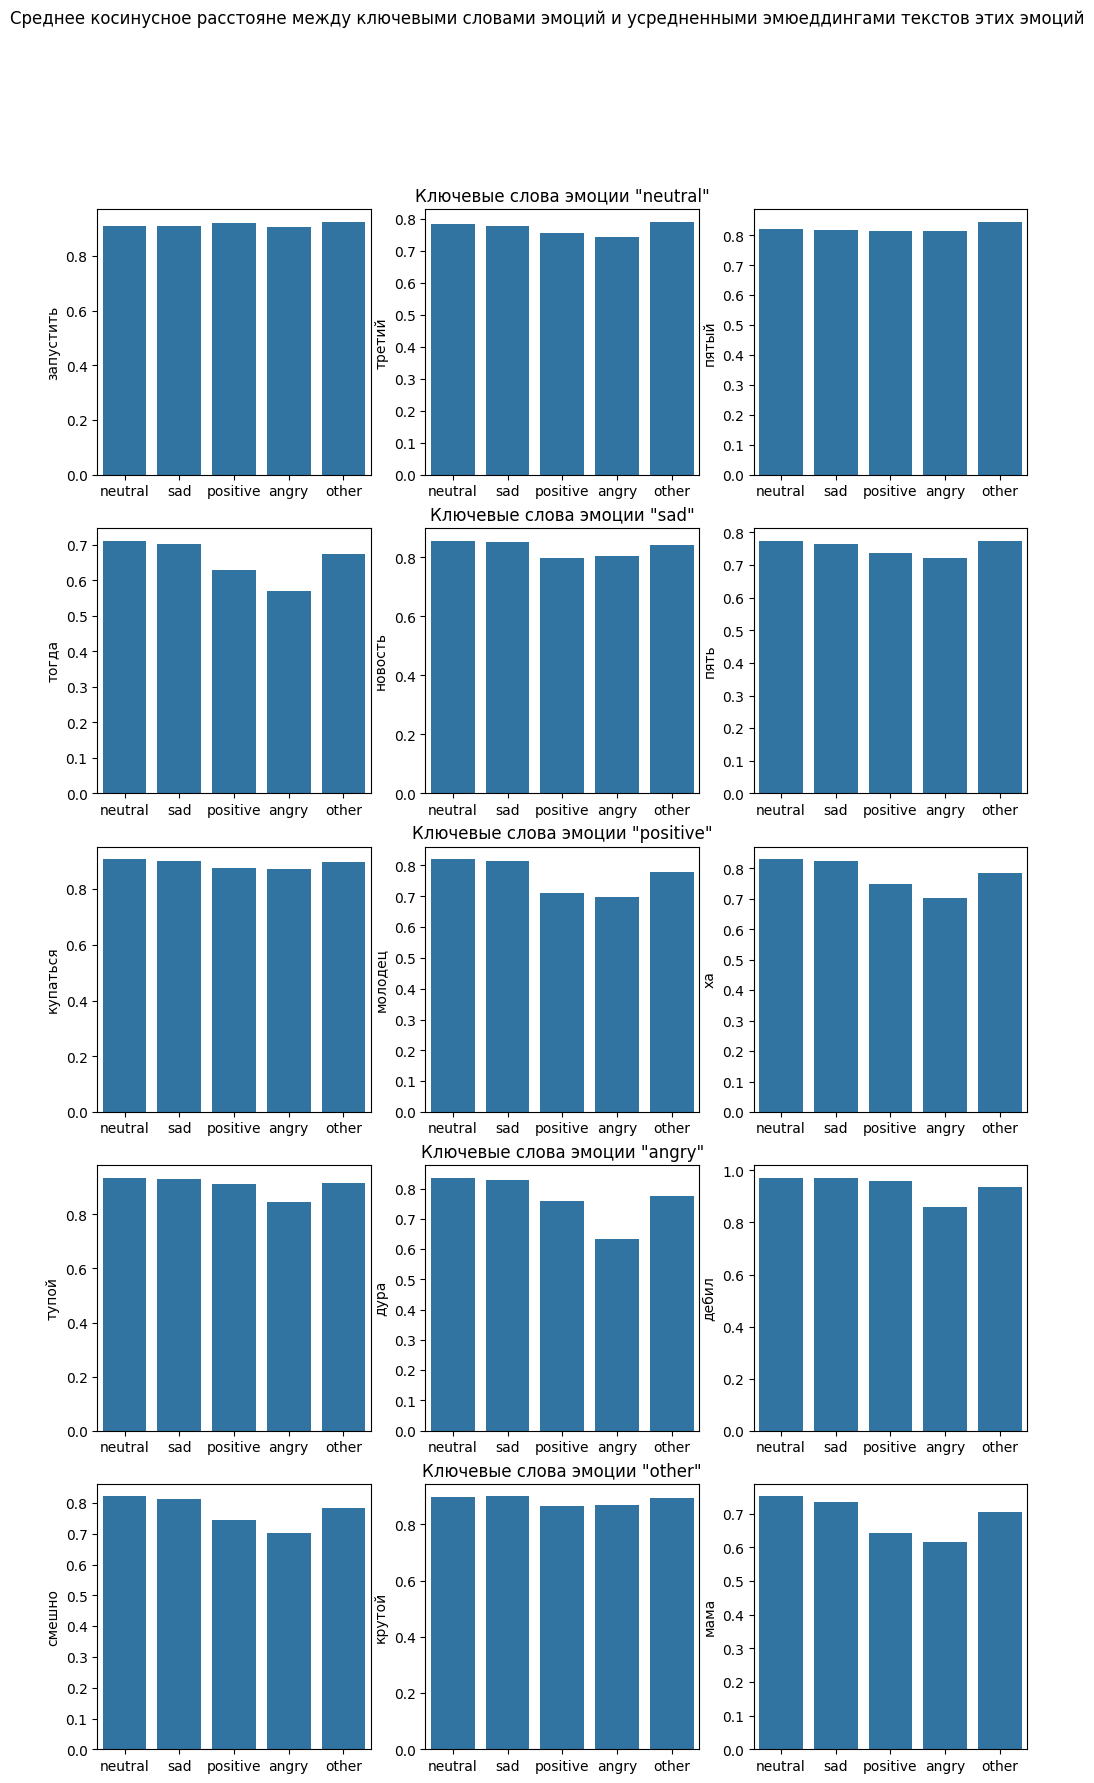

In [ ]:
fig_size_coef = 4
fig, ax = plt.subplots(nrows=len(emotions), ncols=top_words_quantity, figsize=(top_words_quantity * fig_size_coef, len(emotions) * fig_size_coef))
fig.suptitle('Среднее косинусное расстояне между ключевыми словами эмоций и усредненными эмюеддингами текстов этих эмоций')
for i in range(len(emotions)):
    for j in range(top_words_quantity):
        # sns.barplot(key_word_emotion_df.iloc[:, i * top_words_quantity + j])
        column_i = i * top_words_quantity + j
        title = key_word_emotion_df.columns[column_i]
        # sns.barplot(data=key_word_emotion_df.iloc[:, min(13, i * top_words_quantity + j)], ax=ax[i,j])
        sns.barplot(data=key_word_emotion_df.iloc[:, i * top_words_quantity + j], ax=ax[i,j], legend=False)
        if j == (top_words_quantity>>1):
            ax[i,j].title.set_text(f'Ключевые слова эмоции "{emotions[i]}"')
            
            

In [ ]:
3 > (5>>1)

True

In [ ]:
key_word_emotion_df.iloc[:,13]

neutral     0.898952
sad         0.899351
positive    0.866759
angry       0.867078
other       0.894292
Name: крутой, dtype: float64

# Train language model

In [7]:
raw_crowd_train.shape, raw_crowd_test.shape

((906953, 9), (79088, 9))

In [8]:
raw_crowd_train.head(2)

,hash_id,audio_path,duration,annotator_emo,golden_emo,annotator_id,speaker_text,speaker_emo,source_id
0,475e76f77ac1ed7cabafca740b15b32a,wavs/475e76f77ac1ed7cabafca740b15b32a.wav,2.453,angry,NaN,858305a5450b7bd1288ba0053b1cd1c1,не надо не надо не надо не надо,angry,fa136da095807ea6cd18dd6e2f58d4d0
1,2f9438ef68395c70a8714dc373a49d11,wavs/2f9438ef68395c70a8714dc373a49d11.wav,4.640,neutral,NaN,858305a5450b7bd1288ba0053b1cd1c1,фозил кори mp три,neutral,3d436884cbbe25373914f8768de494f7


In [9]:
raw_crowd_train[SPEAKER_EMOTION_FIELD_NAME].head()

0      angry
1    neutral
2        NaN
3    neutral
4    neutral
Name: speaker_emo, dtype: object

In [10]:
raw_crowd_train[SPEAKER_TEXT_FIELD_NAME].head()

0            не надо не надо не надо не надо
1                          фозил кори mp три
2                                        NaN
3                  сколько стоит на керамбит
4    афина когда закончится эта телепередача
Name: speaker_text, dtype: object

In [20]:
text_2_emotion_train:pd.DataFrame = raw_crowd_train[[TEXT_2_EMOTION_FEATURE_FIELD_NAME, TEXT_2_EMOTION_TARGET_FIELD_NAME]].dropna().sample(TRAIN_PART_SIZE, random_state=RANDOM_SEED)
text_2_emotion_test:pd.DataFrame = raw_crowd_test[[TEXT_2_EMOTION_FEATURE_FIELD_NAME, TEXT_2_EMOTION_TARGET_FIELD_NAME]].dropna().sample(TEST_PART_SIZE, random_state=RANDOM_SEED)
print(text_2_emotion_train.shape, text_2_emotion_test.shape)
# text_2_emotion_train.head()

(200000, 2) (40000, 2)


In [21]:
X_train_series, y_train_series = text_2_emotion_train[TEXT_2_EMOTION_FEATURE_FIELD_NAME], text_2_emotion_train[TEXT_2_EMOTION_TARGET_FIELD_NAME]
print(X_train_series.shape, y_train_series.shape)
X_test_series, y_test_series = text_2_emotion_test[TEXT_2_EMOTION_FEATURE_FIELD_NAME], text_2_emotion_test[TEXT_2_EMOTION_TARGET_FIELD_NAME]
print(X_test_series.shape, y_test_series.shape)


(200000,) (200000,)
(40000,) (40000,)


In [22]:
TARGET_COL_NAMES:List[str] = sorted(list(y_train_series.unique()))
TARGET_COL_NAMES

['angry', 'neutral', 'positive', 'sad']

In [23]:
TARGET_INDEX_2_NAME=dict(enumerate(TARGET_COL_NAMES))
TARGET_NAME_2_INDEX={v:k for k, v in TARGET_INDEX_2_NAME.items()}
TARGET_INDEX_2_NAME, TARGET_NAME_2_INDEX


({0: 'angry', 1: 'neutral', 2: 'positive', 3: 'sad'},
 {'angry': 0, 'neutral': 1, 'positive': 2, 'sad': 3})

In [24]:
torch.Tensor(pd.get_dummies(y_train_series.head(1000)).astype(int).to_numpy())

tensor([[0., 0., 0., 1.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        ...,
        [0., 1., 0., 0.],
        [0., 0., 0., 1.],
        [0., 1., 0., 0.]])

In [25]:
max_words_quantity = text_2_emotion_train[SPEAKER_TEXT_FIELD_NAME].apply(lambda x: len(x.split())).max()
max_words_quantity

np.int64(49)

In [26]:
X_train:torch.Tensor = texts_series_2_tensor(X_train_series, torch_unified_size=max_words_quantity, word_tensor_length=NAVEC_EMBEDDINGS_SIZE)
X_test:torch.Tensor = texts_series_2_tensor(X_test_series, torch_unified_size=max_words_quantity, word_tensor_length=NAVEC_EMBEDDINGS_SIZE)
X_train.shape, X_test.shape

NameError: name 'texts_series_2_tensor' is not defined

In [26]:
y_train:torch.Tensor = torch.Tensor(pd.get_dummies(y_train_series, columns=TARGET_COL_NAMES).to_numpy())
y_test:torch.Tensor = torch.Tensor(pd.get_dummies(y_test_series, columns=TARGET_COL_NAMES).to_numpy())

In [28]:
class LSTMModel_many_layers(nn.Module):
    def __init__(self, input_size, hidden_size_1, output_size):
        super(LSTMModel_many_layers, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size_1, batch_first=True, num_layers=30, dropout=0.5)
        self.fc = nn.Linear(hidden_size_1, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :]) 
        return out

# is_GRU_unit:bool = False
# class GRU(nn.Module):
#     def __init__(self, input_size, output_size=1, hidden_size=10, num_layers=3):
#         super(GRU, self).__init__()
#         self.gru = nn.GRU(
#             input_size=input_size,
#             hidden_size=hidden_size,
#             num_layers=num_layers,
#             batch_first=True,
#             )
#         self.fc = nn.Linear(hidden_size, output_size)

    
#     def forward(self, x):

#         h_0 = torch.zeros(3, batch_size, hidden_size)
#         out, h_n = self.gru(x, h_0)
#         last_hidden_state = out[:, -1, :]
#         output = self.fc(last_hidden_state)
#         return output

# model = LSTMModel_1_layer(input_size, hidden_size_1=5, output_size=output_size)
model = LSTMModel_many_layers(NAVEC_EMBEDDINGS_SIZE, hidden_size_1=10, output_size=len(TARGET_COL_NAMES))

In [29]:
criterion = nn.CrossEntropyLoss()  # Suitable for multi-class classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [30]:
# train_sequences_tensor, train_targets_tensor = torch.tensor(train_sequences, dtype=torch.float32), torch.tensor(train_targets, dtype=torch.float32)
# test_sequences_tensor, test_targets_tensor = torch.tensor(test_sequences, dtype=torch.float32), torch.tensor(test_targets, dtype=torch.float32)


# criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

best_model_state = None
min_test_loss:Optional[float] = None

num_epochs = int(10)

loss_values = []
test_loss_values = []
    
for epoch in tqdm(range(num_epochs)):
    model.train()
    

    outputs = model(X_train)
    loss = criterion(outputs.squeeze(), y_train)


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        with torch.no_grad():
            test_pred = model(X_test)
            test_loss_item = criterion(test_pred.squeeze(), y_test).item()
            train_loss_item = loss.item()
            loss_values.append(train_loss_item)
            test_loss_values.append(test_loss_item)
            print(f'Epoch [{epoch + 1}/{num_epochs}], loss: {train_loss_item:.4f}, test loss: {test_loss_item:.4f}')

            if min_test_loss is None or test_loss_item < min_test_loss:
                min_test_loss = test_loss_item
                best_model_state = deepcopy(model)
            # save best version of model 
            
    # h_0 = torch.zeros(3, batch_size, hidden_size)            

        

  0%|          | 0/100 [00:00<?, ?it/s]

: 

: 

: 

<Axes: >

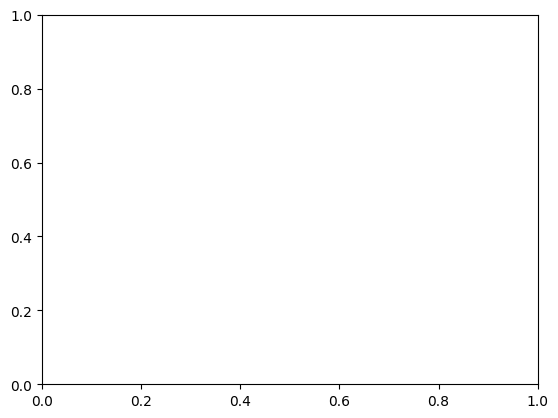

In [ ]:
losses = pd.DataFrame(
    [
        pd.Series(
            loss_values, 
            name ='train'
        ), 
        pd.Series(
            test_loss_values, 
            name ='test'
        )
    ]
).T
sns.lineplot(losses)
# losses

In [ ]:
test_pred = best_model_state(X_test).squeeze()
test_pred.shape, test_pred[:5]

(torch.Size([10000, 4]),
 tensor([[-0.2608,  0.6167, -0.5032,  0.6201],
         [-0.1340,  0.6750, -0.5968,  0.6826],
         [-0.2587,  0.7305, -0.6085,  0.8016],
         [-0.2998,  0.7507, -0.6063,  0.7672],
         [-0.2017,  0.6446, -0.5351,  0.6327]], grad_fn=<SliceBackward0>))

In [ ]:
test_pred_argmax = test_pred.argmax(
    dim=1,
)

In [ ]:
test_pred_argmax[:5]

tensor([3, 3, 3, 3, 1])

In [ ]:
pd.Series(test_pred_argmax).value_counts()

3    6437
1    3563
Name: count, dtype: int64

In [ ]:
# test_pred
y_test_argmax = y_test.argmax(
    dim=1,
)

In [ ]:
pd.Series(y_test_argmax).value_counts()

1    4500
3    3556
0    1076
2     868
Name: count, dtype: int64

In [ ]:
y_test_argmax[:5]

tensor([3, 1, 2, 1, 1])

In [ ]:
# test_targets
ys = pd.concat(
    [
        pd.Series(test_pred_argmax.detach().numpy(), name=PREDICTIONS_COL_NAME), 
        pd.Series(y_test_argmax.detach().numpy(), name=TRUE_COL_NAME),
    ],
    axis=1
)

metrics_report = classification_report(ys[TRUE_COL_NAME], y_pred = ys[PREDICTIONS_COL_NAME], target_names=list(TARGET_NAME_2_INDEX.keys()))
# ys
# pd.Series(test_pred.detach().numpy()).head(), pd.Series(test_targets).head()

/data/vkiselev/projects/univer/deploma/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/vkiselev/projects/univer/deploma/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/vkiselev/projects/univer/deploma/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [ ]:
print(metrics_report)

              precision    recall  f1-score   support

       angry       0.00      0.00      0.00      1076
     neutral       0.46      0.36      0.40      4500
    positive       0.00      0.00      0.00       868
         sad       0.35      0.64      0.45      3556

    accuracy                           0.39     10000
   macro avg       0.20      0.25      0.21     10000
weighted avg       0.33      0.39      0.34     10000



In [ ]:
# pd.Series(y_train.maxa)

AttributeError: 'Tensor' object has no attribute 'maxa'

# Train model only on texts

In [34]:
['angry', 'neutral', 'positive', 'sad']

['angry', 'neutral', 'positive', 'sad']

In [45]:
class DushaEmotion(Enum):
    angry = 0
    neutral = 1
    positive = 2
    sad = 3

In [59]:
# DushaEmotion['angry']
type(getattr(DushaEmotion,'angry').value)

int

In [46]:
class RuBERTTine2Emotion(Enum):
    admiration = DushaEmotion.positive
    amusement = DushaEmotion.positive
    anger = DushaEmotion.angry
    annoyance = DushaEmotion.angry
    approval = DushaEmotion.neutral # positive
    caring = DushaEmotion.positive
    confusion = DushaEmotion.angry # neutral, sad
    curiosity = DushaEmotion.positive
    desire = DushaEmotion.neutral
    disappointment = DushaEmotion.sad
    disapproval = DushaEmotion.sad
    disgust = DushaEmotion.sad
    embarrassment = DushaEmotion.neutral
    excitement = DushaEmotion.positive
    fear = DushaEmotion.sad
    gratitude = DushaEmotion.neutral
    grief = DushaEmotion.sad
    joy = DushaEmotion.positive
    love = DushaEmotion.positive
    nervousness = DushaEmotion.sad
    optimism = DushaEmotion.positive
    pride = DushaEmotion.positive
    realization = DushaEmotion.neutral
    relief = DushaEmotion.positive
    remorse = DushaEmotion.neutral
    sadness = DushaEmotion.sad
    surprise = DushaEmotion.positive
    neutral = DushaEmotion.neutral


In [87]:
# RuBERTTine2Emotion.admiration
def RuBERTTine2Emotion_name_2_Dusha_emotion(emotion_name:str):
    return getattr(RuBERTTine2Emotion, emotion_name).value.value

RuBERTTine2Emotion_name_2_Dusha_emotion('nervousness')

3

In [60]:
def raw_crowd_ds_2_text_emotion_df(
    raw_crowd:pd.DataFrame,
    text_field_name:str = SPEAKER_TEXT_FIELD_NAME,
    speaker_emotion_field_name:str = SPEAKER_EMOTION_FIELD_NAME
    ):
    df = raw_crowd[[text_field_name, speaker_emotion_field_name]].dropna().drop_duplicates()
    # labelencoder = LabelEncoder()
    df[speaker_emotion_field_name] = df[speaker_emotion_field_name].apply(lambda x: DushaEmotion[x].value)
    return df

In [61]:
# Example: Load a dataset from a CSV file
# dataset = load_dataset('csv', data_files='path_to_your_dataset.csv')


In [62]:
raw_crowd_train.head()

,hash_id,audio_path,duration,annotator_emo,golden_emo,annotator_id,speaker_text,speaker_emo,source_id
0,475e76f77ac1ed7cabafca740b15b32a,wavs/475e76f77ac1ed7cabafca740b15b32a.wav,2.453000,angry,NaN,858305a5450b7bd1288ba0053b1cd1c1,не надо не надо не надо не надо,angry,fa136da095807ea6cd18dd6e2f58d4d0
1,2f9438ef68395c70a8714dc373a49d11,wavs/2f9438ef68395c70a8714dc373a49d11.wav,4.640000,neutral,NaN,858305a5450b7bd1288ba0053b1cd1c1,фозил кори mp три,neutral,3d436884cbbe25373914f8768de494f7
2,9937036a9c0dba20eecbffddd00f2be2,wavs/9937036a9c0dba20eecbffddd00f2be2.wav,4.341750,neutral,2.0,858305a5450b7bd1288ba0053b1cd1c1,NaN,NaN,NaN
3,fb0ae78586a235018103acec22a80a8f,wavs/fb0ae78586a235018103acec22a80a8f.wav,3.900562,neutral,NaN,858305a5450b7bd1288ba0053b1cd1c1,сколько стоит на керамбит,neutral,80bc833cf6b3f106d2e8991783a31e2b
4,196dcf9e1aaac46c2aee45e7f6adfb92,wavs/196dcf9e1aaac46c2aee45e7f6adfb92.wav,4.780000,neutral,NaN,858305a5450b7bd1288ba0053b1cd1c1,афина когда закончится эта телепередача,neutral,bd78f079676fa5f1ed17253c9a440cc6


In [63]:
raw_crowd_train.shape

(906953, 9)

In [64]:
raw_crowd_test.head()

,hash_id,audio_path,duration,annotator_emo,golden_emo,annotator_id,speaker_text,speaker_emo,source_id
0,9e9961c53ca6eeb440b217e539fbf46c,wavs/9e9961c53ca6eeb440b217e539fbf46c.wav,5.82,neutral,NaN,858305a5450b7bd1288ba0053b1cd1c1,я слушаю,neutral,4282ddc30d71ef420e202e0c60391e9f
1,0166f65a30354db8282682b1a280e64c,wavs/0166f65a30354db8282682b1a280e64c.wav,3.70,sad,NaN,858305a5450b7bd1288ba0053b1cd1c1,каким стал сбер,neutral,d70dc98ed56e9362eaefefb7b2827c8f
2,d49a6b560155831725a7bdc7d0a96099,wavs/d49a6b560155831725a7bdc7d0a96099.wav,4.38,neutral,NaN,858305a5450b7bd1288ba0053b1cd1c1,где родился шерлок холмс,neutral,0ee35d2abecf4272ecc8e1539b0839d8
3,c6852b0925797612d7b6724da8cbe7b4,wavs/c6852b0925797612d7b6724da8cbe7b4.wav,8.58,neutral,NaN,858305a5450b7bd1288ba0053b1cd1c1,открой в браузере ennio morricone,neutral,0855e363c1787df1592f58f7a27ebe13
4,0166f65a30354db8282682b1a280e64c,wavs/0166f65a30354db8282682b1a280e64c.wav,3.70,sad,NaN,a5562e26cd8f1949488a2d1e1e549d97,каким стал сбер,neutral,d70dc98ed56e9362eaefefb7b2827c8f


In [113]:
X_TRAIN_SIZE:int = int(1e4)
X_TEST_FRACTION:float = 0.2
X_train = raw_crowd_ds_2_text_emotion_df(raw_crowd_train)[:X_TRAIN_SIZE]
X_train.head()

,speaker_text,speaker_emo
0,не надо не надо не надо не надо,0
1,фозил кори mp три,1
3,сколько стоит на керамбит,1
4,афина когда закончится эта телепередача,1
5,где проживают дети путина тихонова и воронцова,1


In [114]:
X_train.shape

(10000, 2)

In [115]:
# len(X_train[SPEAKER_EMOTION_FIELD_NAME].unique())

In [116]:
X_train.duplicated().sum()

np.int64(0)

In [117]:
X_train_path:Path = Path('/home/vkiselev/data/other/univer/deploma/dusha/my/text_model/X_train.csv')
X_train.to_csv(X_train_path, index=False)

In [125]:
X_test = raw_crowd_ds_2_text_emotion_df(raw_crowd_test)[:int(X_TRAIN_SIZE*X_TEST_FRACTION)]
print(X_test.shape)
X_test.head()

(2000, 2)


,speaker_text,speaker_emo
0,я слушаю,1
1,каким стал сбер,1
2,где родился шерлок холмс,1
3,открой в браузере ennio morricone,1
12,а там и ева проснулись с утра,2


In [119]:
X_test[SPEAKER_EMOTION_FIELD_NAME].unique()

array([1, 2, 0, 3])

In [120]:
X_test_path:Path = Path('/home/vkiselev/data/other/univer/deploma/dusha/my/text_model/X_test.csv')
X_test.to_csv(X_test_path, index=False)

In [121]:
# import pandas as pd
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import classification_report, accuracy_score
# from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
# import torch

# # Load your dataframes
# # X_train and X_test should already be defined with 'speaker_text' and 'speaker_emo'

# # Encode the labels
# label_map = {label: idx for idx, label in enumerate(X_train['speaker_emo'].unique())}
# X_train['label'] = X_train['speaker_emo'].map(label_map)
# X_test['label'] = X_test['speaker_emo'].map(label_map)

# # Load BERT tokenizer
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# # Tokenize the input texts
# train_encodings = tokenizer(list(X_train['speaker_text']), truncation=True, padding=True)
# test_encodings = tokenizer(list(X_test['speaker_text']), truncation=True, padding=True)

# # Create a dataset class
# class EmotionDataset(torch.utils.data.Dataset):
#     def __init__(self, encodings, labels):
#         self.encodings = encodings
#         self.labels = labels

#     def __getitem__(self, idx):
#         item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
#         item['labels'] = torch.tensor(self.labels[idx])
#         return item

#     def __len__(self):
#         return len(self.labels)

# # Prepare datasets
# train_dataset = EmotionDataset(train_encodings, list(X_train['label']))
# test_dataset = EmotionDataset(test_encodings, list(X_test['label']))

# # Load BERT model for sequence classification
# model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_map))

# # Define training arguments
# training_args = TrainingArguments(
#     output_dir='./results',
#     num_train_epochs=1,
#     per_device_train_batch_size=8,
#     per_device_eval_batch_size=8,
#     warmup_steps=500,
#     weight_decay=0.01,
#     logging_dir='./logs',
#     logging_steps=10,
#     evaluation_strategy="epoch",
# )

# # Create Trainer instance
# trainer = Trainer(
#     model=model,
#     args=training_args,
#     train_dataset=train_dataset,
#     eval_dataset=test_dataset,
# )



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/data/vkiselev/projects/univer/deploma/venv/lib/python3.11/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [120]:
# Train the model
trainer.train()

Epoch,Training Loss,Validation Loss
1,1.397000,1.336874


TrainOutput(global_step=13, training_loss=1.393738893362192, metrics={'train_runtime': 12.2671, 'train_samples_per_second': 8.152, 'train_steps_per_second': 1.06, 'total_flos': 10072400956800.0, 'train_loss': 1.393738893362192, 'epoch': 1.0})

In [121]:
# Evaluate the model
predictions, labels, _ = trainer.predict(test_dataset)
predicted_labels = predictions.argmax(axis=1)

# Print evaluation metrics
print("Accuracy:", accuracy_score(labels, predicted_labels))
print(classification_report(labels, predicted_labels, target_names=list(label_map.keys())))

Accuracy: 0.35


/data/vkiselev/projects/univer/deploma/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TypeError: object of type 'numpy.int64' has no len()

# Load some model

In [80]:
from transformers import pipeline

# Load the pretrained emotion classification model for Russian
rubert_tiny2 = pipeline("text-classification", model="seara/    ")

# Define your texts for classification
texts = [
    "Я очень зол на тебя!",  # Angry
    "Сегодня обычный день.",  # Neutral
    "Мне очень нравится эта идея!",  # Positive
    "Мне грустно и одиноко."  # Sad
]

# Perform inference on the texts
results = rubert_tiny2(texts)

# Print the results
for text, result in zip(texts, results):
    print(f"Text: {text}\nEmotion: {result['label']}, Score: {result['score']:.2f}\n")


Device set to use cpu


Text: Я очень зол на тебя!
Emotion: neutral, Score: 0.21

Text: Сегодня обычный день.
Emotion: neutral, Score: 0.89

Text: Мне очень нравится эта идея!
Emotion: love, Score: 0.32

Text: Мне грустно и одиноко.
Emotion: sadness, Score: 0.72



In [126]:
X_test.head()

,speaker_text,speaker_emo
0,я слушаю,1
1,каким стал сбер,1
2,где родился шерлок холмс,1
3,открой в браузере ennio morricone,1
12,а там и ева проснулись с утра,2


In [127]:
y_true = X_test[SPEAKER_EMOTION_FIELD_NAME]

In [128]:
X_test.shape

(2000, 2)

In [129]:
rubert_predictions = pd.DataFrame(rubert_tiny2(X_test[SPEAKER_TEXT_FIELD_NAME].to_list()))

In [136]:
y_pred = rubert_predictions['label'].apply(RuBERTTine2Emotion_name_2_Dusha_emotion)
y_pred.head()

0    1
1    1
2    1
3    1
4    1
Name: label, dtype: int64

In [134]:
# y_pred = pd.Series(map(lambda x: RuBERTTine2Emotion_name_2_Dusha_emotion(x['label']), rubert_tiny2(X_test[SPEAKER_TEXT_FIELD_NAME].to_list())))
# y_pred.head()

In [137]:
y_true.shape, y_pred.shape

((2000,), (2000,))

In [138]:
print(classification_report(y_true=y_true, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.81      0.11      0.19       600
           1       0.42      0.92      0.58       697
           2       0.67      0.36      0.47       469
           3       0.46      0.25      0.32       234

    accuracy                           0.47      2000
   macro avg       0.59      0.41      0.39      2000
weighted avg       0.60      0.47      0.41      2000

